In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  

# Análise de 1 Módulo Fotovoltaico

In [62]:
class PV_Model():

  def __init__(self, rad_inc, temp_amb, n_serie=1, n_paralelo=1,n_placas=1, modelo_name=None, dados_placa = None):

    #--------- Dados
    self.modelo_name = modelo_name
    self.temp_amb = temp_amb
    self.rad_inc = rad_inc
    self.n_serie = n_serie
    self.n_paralelo = n_paralelo
    self.n_placas = n_placas

    if dados_placa != None:
      self.dados_placa = dados_placa
    else:
      self.dados_placa = {
                  
          #-------
          "i_cc" : 3.15,         # Corrente de curto [A]
          "a_cc" : 0.06e-2,      # Coeficiente de Variação de i_cc pela Temperatura[A/ºC]
          "i_sat" : 1.37e-8,     # Corrente maxima de saturacao
          "i_0" : 3.169958e-6,   #
          
          #------- 
          "temp_nom" : 46,       # Temperatura Nominal [ºC]
          "rad_teste" : 800,     # Condição de Radiação no Teste [W/m²]
          "temp_teste" : 20,     #
          "vel_v" : 1,           #
          "rad_ref" : 1000,      # Condição de Radiação no Teste [W/m²]
          "temp_ref" : 25,       #
          "vel_v_ref" : 1.5,     #
          
          #------ Dimensões       
          "larg" : 10*1e-2,      #
          "comp" : 10*1e-2,      #        
      }

    self.area = self.dados_placa["larg"]*self.dados_placa["comp"]
    self.temp_c = self.temp_amb + ((self.dados_placa["temp_nom"]-20)*self.rad_inc)/self.dados_placa["rad_teste"]
    self.i_L = (self.dados_placa["i_cc"] + self.dados_placa["a_cc"]*(self.temp_c - self.dados_placa["temp_ref"]))*(self.rad_inc/self.dados_placa["rad_ref"])
    
    self.calculate_parameters()

  def calculate_parameters(self):
    
    def i_d(v,i_0):
      k = 1.38e-23
      n = 1
      q = 1.602e-19
      id = i_0*((np.e**(v/0.0291)) -1)
      return id
    
      
    def sum_paralelo(i, n):
      I = [ n*id for id in i ]
      return I

    def sum_serie(v, n):
      V = n*v
      return V
    
    
    v_s = np.arange(0,0.7,0.0001)
    v_list = []
    id_list = []
    for v in v_s:

      id = (i_d(v,self.dados_placa["i_0"]))
      i = self.i_L - id
      if i >= 0:
        v_list.append(sum_serie(v,self.n_serie))
        id_list.append(i)

    id_list = sum_paralelo(id_list, self.n_paralelo)

    self.v_circuito_aberto = v_list[int(np.where(id_list == min(id_list))[0])]
    self.i_curto_circuito = id_list[int(np.where(v_list == min(v_list))[0])]
    self.V_list = v_list
    self.ID_list = id_list

    pot_celula = []
    for i in range(len(v_list)):
      pot_celula.append(float(v_list[i]*id_list[i]))
    
    self.POT_list = pot_celula
    self.max_pot = max(pot_celula)
    self.i_max_pot = id_list[int(np.where(pot_celula==np.amax(pot_celula))[0])]
    self.v_max_pot = v_list[int(np.where(pot_celula==np.amax(pot_celula))[0])]

  def max_rendimento(self):
    return ((self.max_pot)/(self.n_placas*self.area*self.rad_inc))

  def fator_de_forma(self):
    return ((self.max_pot)/(self.v_circuito_aberto*self.i_curto_circuito))
  
  def relatorio_modelo(self):
    print(f'Tensão de Circuito aberto = {self.v_circuito_aberto}')
    print(f'Corrente de Curto Circuito = {self.i_curto_circuito}')
    print(f'Potencia Maxima fornecida pela celula = {self.max_pot}')
    print(f'Corrente de Máxima Potência = {self.i_max_pot}')
    print(f'Tensão de Máxima Potência = {self.v_max_pot}')
    print(f'Máximo Rendimento = {self.max_rendimento()}')
    print(f'Fator de Forma = {self.fator_de_forma()}')




In [63]:
modulo1 = PV_Model(rad_inc=1000,temp_amb=25)
modulo1.relatorio_modelo()

Tensão de Circuito aberto = 0.402
Corrente de Curto Circuito = 3.1694999999999998
Potencia Maxima fornecida pela celula = 0.9579824911945876
Corrente de Máxima Potência = 2.9118008850899315
Tensão de Máxima Potência = 0.329
Máximo Rendimento = 0.09579824911945874
Fator de Forma = 0.75186654768011


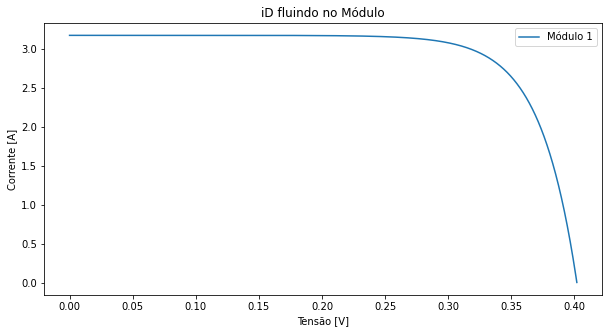

In [64]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("iD fluindo no Módulo")
ax.set_xlabel('Tensão [V]')   
ax.set_ylabel('Corrente [A]')  
plt.plot(modulo1.V_list, modulo1.ID_list, label='Módulo 1')
plt.legend()
plt.show()

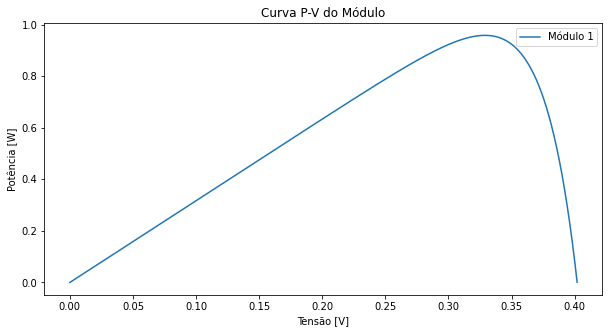

In [65]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Curva P-V do Módulo")
ax.set_xlabel('Tensão [V]')   
ax.set_ylabel('Potência [W]')  
ax.plot(modulo1.V_list, modulo1.POT_list,label='Módulo 1')
plt.legend()
plt.show()

# Análise de N Módulos

In [66]:
modulo1 = PV_Model(rad_inc=1000,temp_amb=25, modelo_name='Modulo 1')
modulo2 = PV_Model(rad_inc=700,temp_amb=25, modelo_name='Modulo 2')
modulo3 = PV_Model(rad_inc=450,temp_amb=25, modelo_name='Modulo 3')
modulo4 = PV_Model(rad_inc=300,temp_amb=25, modelo_name='Modulo 4')
modulo5 = PV_Model(rad_inc=100,temp_amb=25, modelo_name='Modulo 5')


In [67]:
objetos_de_modulo = [modulo1, modulo2, modulo3, modulo4, modulo5]

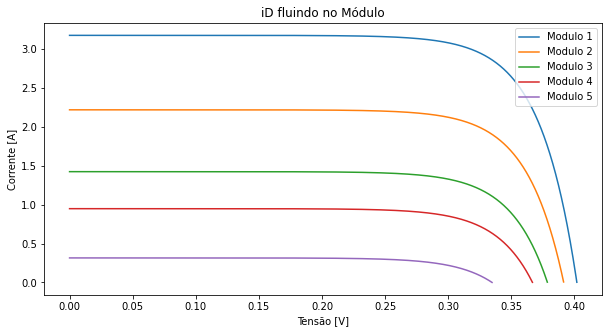

In [68]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("iD fluindo no Módulo")
ax.set_xlabel('Tensão [V]')   
ax.set_ylabel('Corrente [A]') 
for mod in objetos_de_modulo:
    plt.plot(mod.V_list, mod.ID_list, label=mod.modelo_name)
plt.legend()
plt.show()